<a href="https://colab.research.google.com/github/swilsonmfc/anomaly/blob/master/AnomalyMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection Machine Learning
![alt text](https://d1cnss1t6ao97n.cloudfront.net/mstatic/ea04db5/content/uploads/2014/08/Automated-anomaly-detection.png)

# Setup

In [ ]:
pip install pyod

In [ ]:
pip install tsfresh

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyod.models.iforest import IsolationForest
from pyod.models.iforest import IForest
from pyod.models.loda import LODA
from pyod.models.lof import LOF
from pyod.models.knn import KNN

from pyod.utils import evaluate_print 
from pyod.utils.example import visualize

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.preprocessing import StandardScaler

from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import select_features

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

In [ ]:
!git clone https://github.com/swilsonmfc/anomaly

fatal: destination path 'anomaly' already exists and is not an empty directory.


In [ ]:
cd anomaly

/content/anomaly


In [ ]:
ls data

data_anomaly_ecoli.csv         data_anomaly_shuttle_train.csv
data_anomaly_shuttle.csv       data_anomaly_speech.csv
data_anomaly_shuttle_test.csv  data_anomaly_taxi.csv


In [ ]:
taxi_df = pd.read_csv('data/data_anomaly_taxi.csv')

# EDA

In [ ]:
taxi_df.head()

,TIMESTAMP,VALUE,OUTLIER
0,2014-07-01 00:00:00,10844,0
1,2014-07-01 00:30:00,8127,0
2,2014-07-01 01:00:00,6210,0
3,2014-07-01 01:30:00,4656,0
4,2014-07-01 02:00:00,3820,0


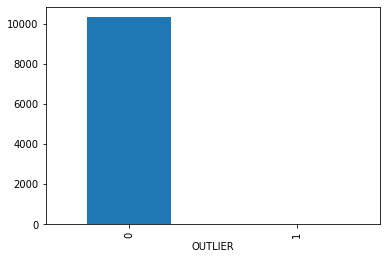

In [ ]:
taxi_df.groupby('OUTLIER').size().plot.bar()

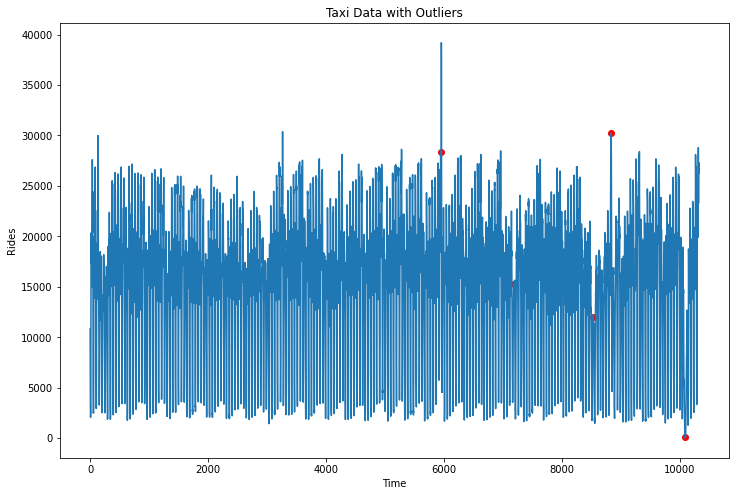

In [ ]:
taxi_df['VALUE'].plot(figsize=(12,8))
outliers_df = taxi_df[taxi_df.OUTLIER == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

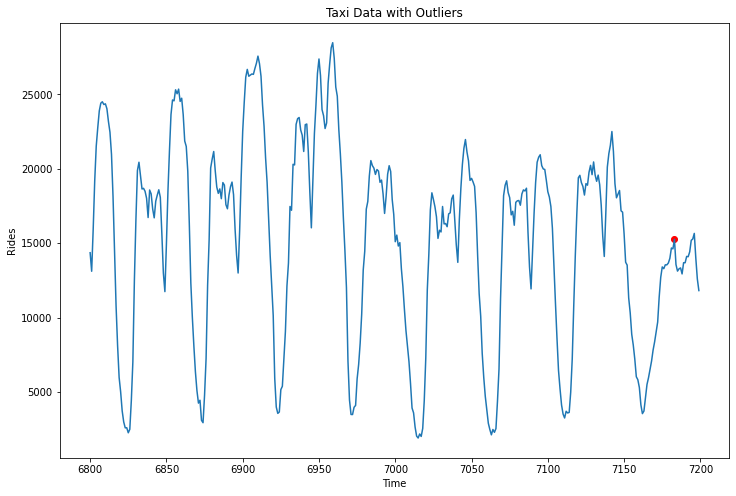

In [ ]:
subset_df = taxi_df[6800:7200]
subset_df['VALUE'].plot(figsize=(12,8))
outliers_df = subset_df[subset_df.OUTLIER == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

# Helpers

In [ ]:
def plot_outliers(X, test, pred):
  df = X.copy()
  df['OUTLIER'] = test
  df['PRED']    = pred
  
  df['VALUE'].plot(figsize=(12,8))

  outliers_df = df[df.OUTLIER == 1]
  plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
  outliers_df = df[(df.OUTLIER == 0) & (df.PRED == 1)]
  plt.scatter(outliers_df.index, outliers_df.VALUE, color='red', marker='x') 
  outliers_df = df[(df.OUTLIER == 1) & (df.PRED == 1)]
  plt.scatter(outliers_df.index, outliers_df.VALUE, color='green');
  
  plt.xlabel('Time')
  plt.ylabel('Rides')
  plt.title('Taxi Data with Outliers');

def evaluate_outliers(X, y, pred):
  plot_outliers(X, y, pred)
  plot_confusion(y, pred)
  print_classification_report(y, pred)

def print_classification_report(test, pred, target_names=['NORMAL', 'OUTLIER']):
  report = classification_report(test, pred, target_names=target_names)
  print(report)  

def plot_confusion(test, pred, class_names=['NORMAL', 'OUTLIER']):
  cm = confusion_matrix(test, pred)
  df = pd.DataFrame(cm, class_names, class_names)
  plt.figure(figsize=(10, 10))
  sns.heatmap(df, annot=True, fmt='d', cmap='BuGn')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  plt.show()

def plot_roc_curve(test, pred_proba):
  fpr, tpr, _ = roc_curve(test,  pred_proba)
  auc = roc_auc_score(test, pred_proba)
  plt.figure(figsize=(10, 10))
  plt.plot(fpr, tpr, label=f'AUC = {auc}')
  plt.plot([0,1], [0,1], linestyle='--')
  plt.title('ROC Curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc=4)
  plt.show()

def plot_precision_recall_curve(test, pred_proba):
  precision, recall, _ = precision_recall_curve(test, pred_proba)
  aps = average_precision_score(y_test, pred_proba)
  plt.figure(figsize=(10, 10))
  plt.plot(recall, precision, label=f'Avg Precision = {aps}')
  plt.plot([0,1], [0.5,0.5], linestyle='--')
  plt.fill_between(recall, 0, precision)
  plt.title('Precision Recall Curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(loc=4)
  plt.show()

# Preprocessing

In [ ]:
X_train = taxi_df.copy()
y_train = X_train['OUTLIER'].copy()
X_train = X_train.drop(columns=['TIMESTAMP', 'OUTLIER'])

# Evaluation Metrics
* Accuracy
* Precision
* Recall

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)

# Machine Learning
* PyOD similar to PyCaret (Anomaly Detection)

In [ ]:
X_train = taxi_df.copy()
y_train = X_train['OUTLIER'].copy()
X_train = X_train.drop(columns=['TIMESTAMP', 'OUTLIER'])

In [ ]:
def train(model, X_train, y_train):
  model.fit(X_train)

  y_train_pred   = clf.predict(X_train)
  y_train_proba  = clf.predict_proba(X_train) 
  y_train_scores = clf.decision_function(X_train) 

  evaluate_print(type(model).__name__, y_train, y_train_scores)
  plot_outliers(X_train, y_train, y_train_pred)
  plot_confusion(y_train, y_train_pred)
  print_classification_report(y_train, y_train_pred)

## KNN
![alt text](https://annalyzin.files.wordpress.com/2016/09/knn-layman-explanation-borderless.png?w=820&h=312&crop=1)

* Density approach to identifying outliers
* For an observation, measure the distance to its kth nearest neighbor could be viewed as the outlying score
* Need to pick the number of neighbors (k)
  * Experiment
  * Grid Search
  * Ensemble

### Train

KNN ROC:0.7794, precision @ rank n:0.0


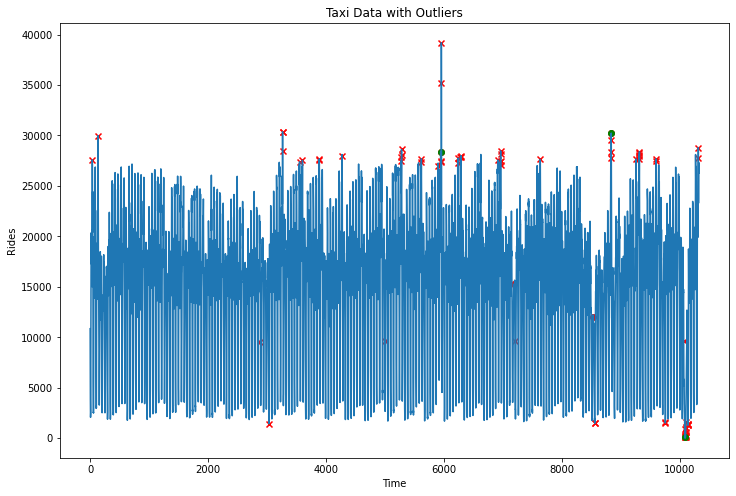

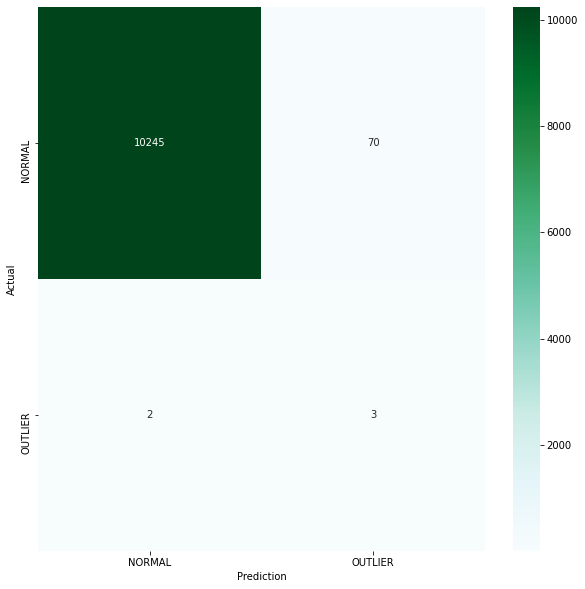

              precision    recall  f1-score   support

      NORMAL       1.00      0.99      1.00     10315
     OUTLIER       0.04      0.60      0.08         5

    accuracy                           0.99     10320
   macro avg       0.52      0.80      0.54     10320
weighted avg       1.00      0.99      1.00     10320



In [ ]:
clf = KNN(contamination=0.01, n_neighbors=5)
train(clf, X_train, y_train)

### Grid Search

In [ ]:
results_knn_df = pd.DataFrame(columns=['K', 'Precision', 'Recall'])
for k in [2, 3, 5, 10, 20, 50, 100, 200]:
  knn = KNN(n_neighbors=k)
  knn.fit(X_train)
  pred = knn.predict(X_train)
  precision = precision_score(y_train, pred)
  recall    = recall_score(y_train, pred)
  results_knn_df.loc[f'KNN-{k}'] = [k, precision, recall]
results_knn_df

,K,Precision,Recall
KNN-2,2.0,0.004425,0.2
KNN-3,3.0,0.007212,0.6
KNN-5,5.0,0.005357,0.6
KNN-10,10.0,0.004342,0.6
KNN-20,20.0,0.003341,0.6
KNN-50,50.0,0.003083,0.6
KNN-100,100.0,0.003018,0.6
KNN-200,200.0,0.002979,0.6


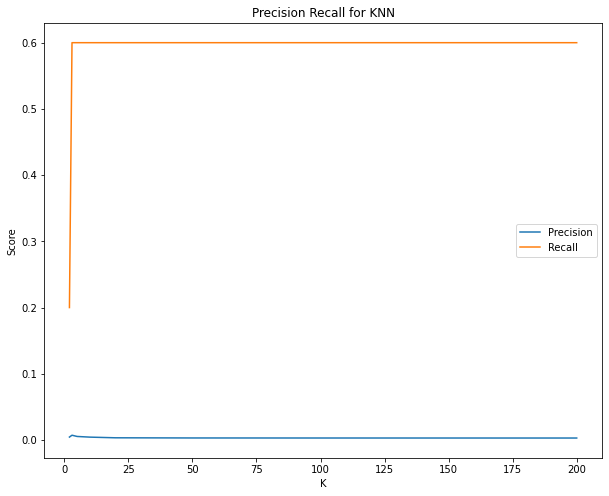

In [ ]:
ax = results_knn_df.plot('K', 'Precision', label='Precision', figsize=(10, 8))
results_knn_df.plot('K', 'Recall', label='Recall', ax=ax)
plt.title('Precision Recall for KNN')
plt.ylabel('Score')
plt.xlabel('K');

## LODA
* Lightweight On-line Detector of Anomalies
* Ensemble method consisting of:
  * Sparse Random Projection (Dimensionality Reduction)
  * Histogram Binning to identify outliers

### Train

LODA ROC:0.8605, precision @ rank n:0.25


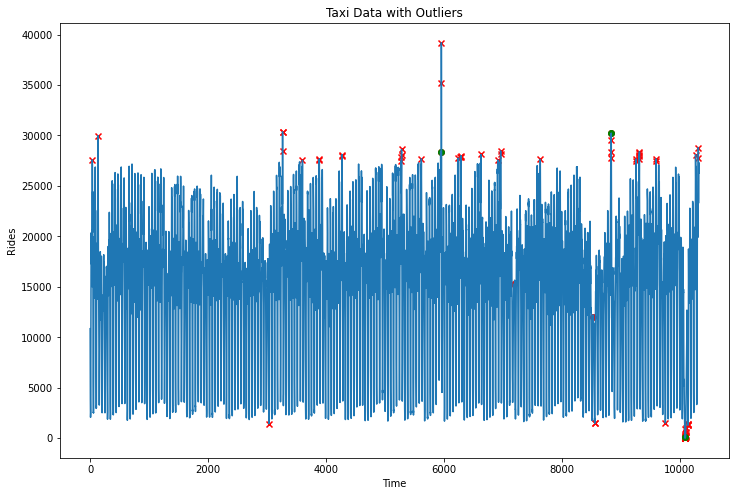

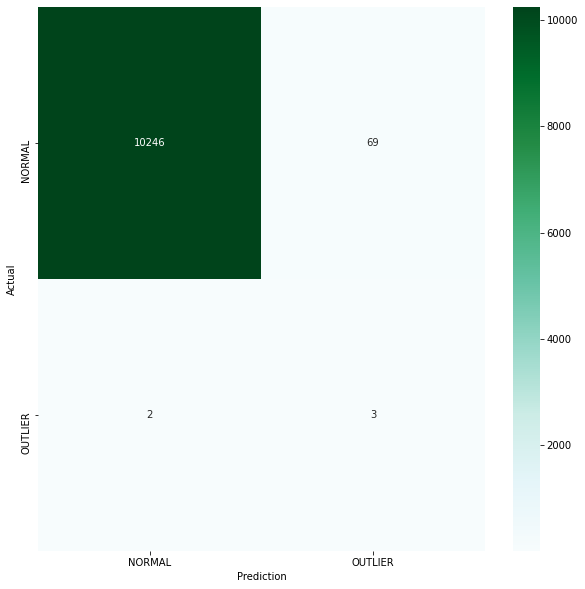

              precision    recall  f1-score   support

      NORMAL       1.00      0.99      1.00     10315
     OUTLIER       0.04      0.60      0.08         5

    accuracy                           0.99     10320
   macro avg       0.52      0.80      0.54     10320
weighted avg       1.00      0.99      1.00     10320



In [ ]:
clf = LODA(contamination=0.01, n_bins=100)
train(clf, X_train, y_train)

### Grid Search

In [ ]:
results_loda_df = pd.DataFrame(columns=['Bins', 'Cuts', 'Precision', 'Recall'])
for bin in [10, 20, 50, 100, 200]:
  for cut in [50, 100, 200, 500, 1000]:
    loda = LODA(n_bins=bin, n_random_cuts=cut)
    loda.fit(X_train)
    pred = loda.predict(X_train)
    precision = precision_score(y_train, pred)
    recall    = recall_score(y_train, pred)
    results_loda_df.loc[f'LODA-{bin}:{cut}'] = [bin, cut, precision, recall]
results_loda_df.pivot(index='Cuts', columns='Bins', values=['Precision', 'Recall'])

Precision                                ... Recall                  
Bins       10.0      20.0      50.0      100.0  ...  20.0  50.0  100.0 200.0
Cuts                                            ...                         
50.0    0.046512  0.004843  0.003024  0.003096  ...    0.4   0.6   0.6   0.6
100.0   0.046512  0.004843  0.003024  0.003096  ...    0.4   0.6   0.6   0.6
200.0   0.046512  0.004843  0.003024  0.003030  ...    0.4   0.6   0.6   0.6
500.0   0.046512  0.004843  0.003024  0.003096  ...    0.4   0.6   0.6   0.6
1000.0  0.046512  0.004843  0.003024  0.003096  ...    0.4   0.6   0.6   0.6

[5 rows x 10 columns]

## Isolation Forest
* Grow tree until all points are in a leaf node
* Make random splits to the data to separate it
* If you can isolate a point in a small number of splits, it's an outlier
* Dense regions require many more slices
* In other words:
  * Depth is small = Outlier
  * Depth is large = Inlier

![alt text](https://pubs.rsc.org/image/article/2016/ay/c6ay01574c/c6ay01574c-f1_hi-res.gif)

### Train

IForest ROC:0.8229, precision @ rank n:0.0


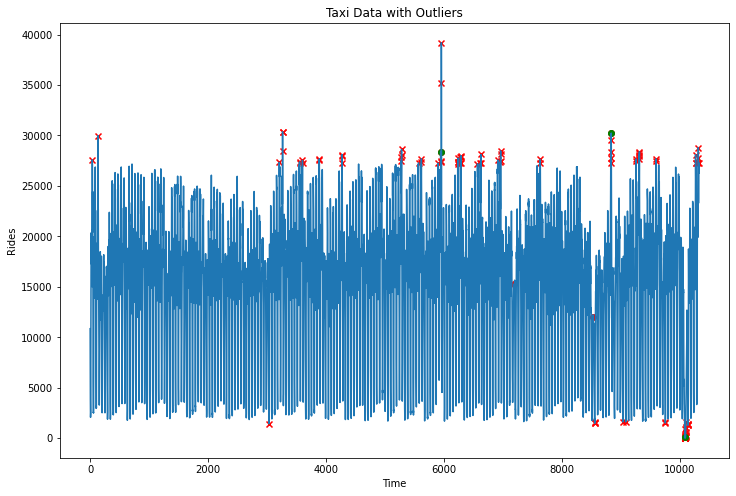

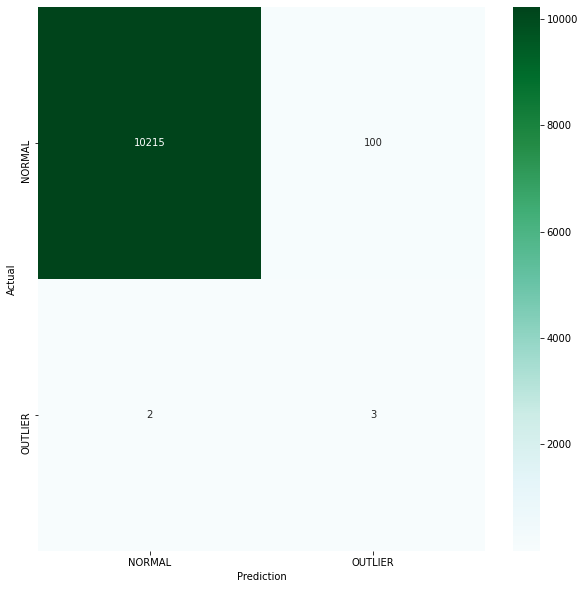

              precision    recall  f1-score   support

      NORMAL       1.00      0.99      1.00     10315
     OUTLIER       0.03      0.60      0.06         5

    accuracy                           0.99     10320
   macro avg       0.51      0.80      0.53     10320
weighted avg       1.00      0.99      0.99     10320



In [ ]:
clf = IForest(contamination=0.01)
train(clf, X_train, y_train)

### Grid Search

In [ ]:
results_isof_df = pd.DataFrame(columns=['Estimators', 'Outliers', 'Precision', 'Recall'])
for n in [1, 2, 5, 10, 50, 100, 200]:
  isof = IForest(contamination=0.01, n_estimators=n)
  isof.fit(X_train)
  pred = isof.predict(X_train)
  precision = precision_score(y_train, pred)
  recall    = recall_score(y_train, pred)
  outliers  = np.sum(pred)
  results_isof_df.loc[f'IForest-{n}'] = [n, outliers, precision, recall]
results_isof_df

,Estimators,Outliers,Precision,Recall
IForest-1,1.0,93.0,0.032258,0.6
IForest-2,2.0,97.0,0.020619,0.4
IForest-5,5.0,88.0,0.022727,0.4
IForest-10,10.0,73.0,0.027397,0.4
IForest-50,50.0,101.0,0.029703,0.6
IForest-100,100.0,103.0,0.029126,0.6
IForest-200,200.0,102.0,0.029412,0.6


## Local Outlier Factor
* Local Outlier Factor is an anomaly scoring technique
* Local refers to the average distance to it's k-nearest neighbors
* It measures the deviation of these distances to estimate density
* A point with low densities relative to its neighbors is likely to be an outlier

![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_lof_outlier_detection_001.png)

### Train

LOF ROC:0.6945, precision @ rank n:0.2


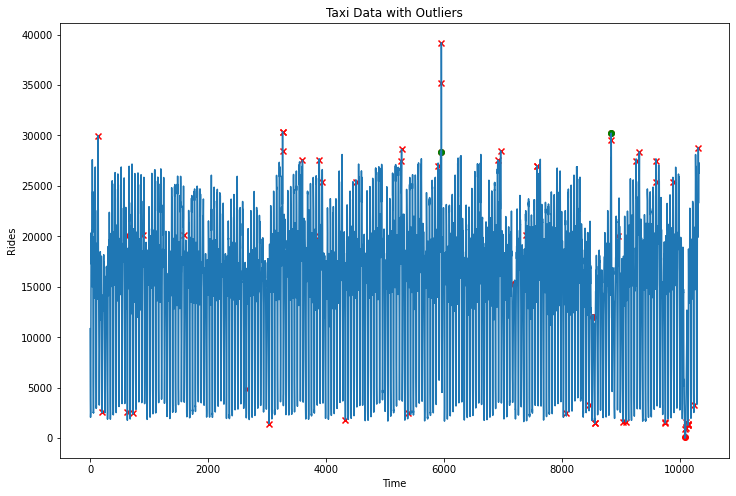

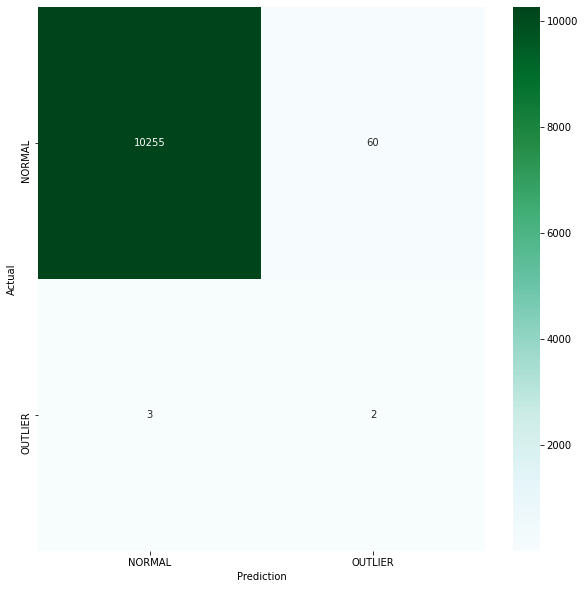

              precision    recall  f1-score   support

      NORMAL       1.00      0.99      1.00     10315
     OUTLIER       0.03      0.40      0.06         5

    accuracy                           0.99     10320
   macro avg       0.52      0.70      0.53     10320
weighted avg       1.00      0.99      1.00     10320



In [ ]:
clf = LOF(contamination=0.01)
train(clf, X_train, y_train)

### Grid Search

In [ ]:
results_lof_df = pd.DataFrame(columns=['Neighbors', 'Outliers', 'Precision', 'Recall'])
for n in [1, 2, 5, 10, 15, 20, 50, 100, 200]:
  lof = LOF(contamination=0.01, n_neighbors=n)
  lof.fit(X_train)
  pred = lof.predict(X_train)
  precision = precision_score(y_train, pred)
  recall    = recall_score(y_train, pred)
  outliers  = np.sum(pred)
  results_lof_df.loc[f'LOF-{n}'] = [n, outliers, precision, recall]
results_lof_df

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Neighbors,Outliers,Precision,Recall
LOF-1,1.0,0.0,0.000000,0.0
LOF-2,2.0,17.0,0.000000,0.0
LOF-5,5.0,36.0,0.000000,0.0
LOF-10,10.0,64.0,0.031250,0.4
LOF-15,15.0,78.0,0.012821,0.2
LOF-20,20.0,62.0,0.032258,0.4
LOF-50,50.0,101.0,0.029703,0.6
LOF-100,100.0,103.0,0.029126,0.6
LOF-200,200.0,103.0,0.029126,0.6


# Ensembling
* Intuition
  * What movie should I see?
  * Ask friends and get their recommendations
    * One friend may know I like a certain type of movie
    * Another may know I like a particular actor
    * Maybe a third knows I prefer older movies or new releases
  * Their recommendations lead to educated guesses or votes
  * I select the movie with the highest number of votes
* Machine learning
  * Models can be good in certain regions of the data
  * By combining models we can attempt to improve accuracy
  * Models to combine shouldn't be highly correlated
  * Ensembling is a must in competitive machine learning


## Build Ensemble

In [ ]:
knn  = KNN(contamination=0.01, n_neighbors=5)
loda = LODA(contamination=0.01, n_bins=100)
isof = IForest(contamination=0.01)
lof  = LOF(contamination=0.01)

names    = ['KNN', 'LODA', 'ISOF', 'LOF']
ensemble = [knn, loda, isof, lof]

for model in ensemble:
  model.fit(X_train)

## Predictions

In [ ]:
predictions = []
probability = []
for model in ensemble: 
  pred  = model.predict(X_train)
  proba = model.predict_proba(X_train)
  predictions.append(pred)
  probability.append(proba)

## Voting
* Unanimous vote
* Majority or other threshold can be appropriate as well

In [ ]:
vote_df = pd.DataFrame(predictions).T
vote_df.columns = names
vote_df['OUTLIER'] = np.where(np.sum(vote_df, axis=1) >= 4, 1, 0)
vote_df

,KNN,LODA,ISOF,LOF,OUTLIER
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
10315,0,0,0,0,0
10316,0,0,0,0,0
10317,0,0,1,0,0
10318,0,0,0,0,0


## Test

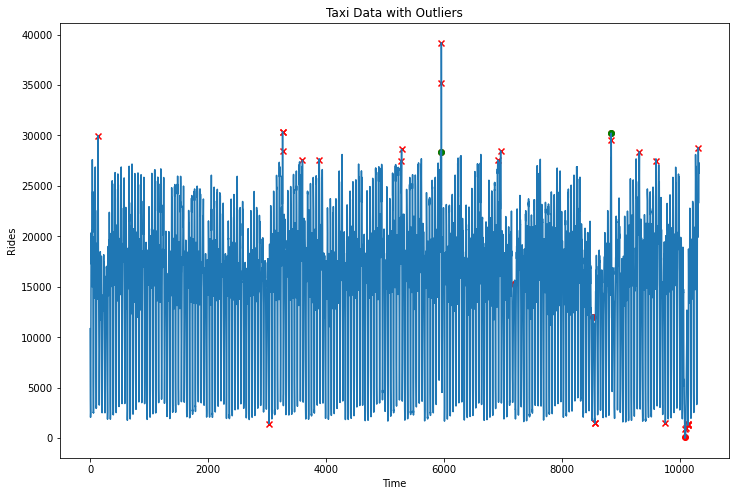

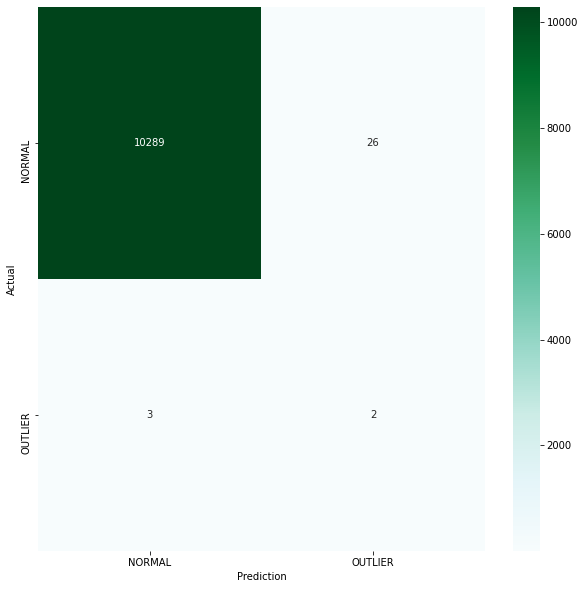

              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00     10315
     OUTLIER       0.07      0.40      0.12         5

    accuracy                           1.00     10320
   macro avg       0.54      0.70      0.56     10320
weighted avg       1.00      1.00      1.00     10320



In [ ]:
plot_outliers(X_train, y_train, vote_df.OUTLIER)
plot_confusion(y_train, vote_df.OUTLIER)
print_classification_report(y_train, vote_df.OUTLIER)

## Notes
* Ensembling improved our precision (0.05) 
* Small, but 25% better than any individual model
* Multiple models removes variance in learners
  * Try different types of models
  * Measure correlation (identify those with lower)
* PyOD has combinations in its API
  * This example was a hard vote 
  * Soft voting (based on probabilities)

# Feature Engineering
* Auto-generate time series features useful for machine learning
* Can be time consuming to produce
* tsfresh library has many possible features implemented

## Generate Features

In [ ]:
tsfresh_df = taxi_df.copy()
tsfresh_df = tsfresh_df.reset_index()
tsfresh_df = tsfresh_df.rename(columns={'index': 'ID'})

In [ ]:
settings = EfficientFCParameters()
features_df = extract_features(tsfresh_df, 
                 column_id='ID', 
                 column_value='VALUE',
                 column_sort='TIMESTAMP',
                 default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 5/5 [04:48<00:00, 57.79s/it]


## Impute & Select

In [ ]:
imputed_df  = impute(features_df)
filtered_df = select_features(imputed_df, y_train)

/usr/local/lib/python3.6/dist-packages/tsfresh/utilities/dataframe_functions.py:173: RuntimeWarning: The columns ['VALUE__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"'
 'VALUE__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"'
 'VALUE__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"'
 'VALUE__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"'
 'VALUE__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"'
 'VALUE__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"'
 'VALUE__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"'
 'VALUE__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"'
 'VALUE__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"'
 'VALUE__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"'
 'VALUE__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"'
 'VALUE__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"'
 'VALUE__agg_linear_tren

## Training Data

In [ ]:
X_train = pd.concat([tsfresh_df, features_df], axis=1)
y_train = X_train['OUTLIER'].copy()
X_train = X_train.drop(columns=['TIMESTAMP', 'OUTLIER'])
X_train = X_train.dropna(axis=1)

In [ ]:
X_train.head()

,ID,VALUE,VALUE__abs_energy,VALUE__absolute_sum_of_changes,"VALUE__agg_autocorrelation__f_agg_""mean""__maxlag_40","VALUE__agg_autocorrelation__f_agg_""median""__maxlag_40","VALUE__agg_autocorrelation__f_agg_""var""__maxlag_40","VALUE__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","VALUE__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","VALUE__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","VALUE__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","VALUE__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""","VALUE__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""mean""","VALUE__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""min""","VALUE__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""var""","VALUE__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","VALUE__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","VALUE__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","VALUE__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""","VALUE__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""max""","VALUE__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","VALUE__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""","VALUE__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""var""","VALUE__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""max""","VALUE__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""mean""","VALUE__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""min""","VALUE__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""var""","VALUE__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""max""","VALUE__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""mean""","VALUE__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""min""","VALUE__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""var""","VALUE__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","VALUE__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""","VALUE__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""min""","VALUE__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""","VALUE__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","VALUE__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""mean""","VALUE__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""min""","VALUE__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","VALUE__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""",...,VALUE__ratio_beyond_r_sigma__r_6,VALUE__ratio_beyond_r_sigma__r_7,VALUE__ratio_value_number_to_time_series_length,VALUE__skewness,VALUE__spkt_welch_density__coeff_2,VALUE__spkt_welch_density__coeff_5,VALUE__spkt_welch_density__coeff_8,VALUE__standard_deviation,VALUE__sum_of_reoccurring_data_points,VALUE__sum_of_reoccurring_values,VALUE__sum_values,VALUE__symmetry_looking__r_0.0,VALUE__symmetry_looking__r_0.05,VALUE__symmetry_looking__r_0.1,VALUE__symmetry_looking__r_0.15000000000000002,VALUE__symmetry_looking__r_0.2,VALUE__symmetry_looking__r_0.25,VALUE__symmetry_looking__r_0.30000000000000004,VALUE__symmetry_looking__r_0.35000000000000003,VALUE__symmetry_looking__r_0.4,VALUE__symmetry_looking__r_0.45,VALUE__symmetry_looking__r_0.5,VALUE__symmetry_looking__r_0.55,VALUE__symmetry_looking__r_0.6000000000000001,VALUE__symmetry_looking__r_0.65,VALUE__symmetry_looking__r_0.7000000000000001,VALUE__symmetry_looking__r_0.75,VALUE__symmetry_looking__r_0.8,VALUE__symmetry_looking__r_0.8500000000000001,VALUE__symmetry_looking__r_0.9,VALUE__symmetry_looking__r_0.9500000000000001,VALUE__time_reversal_asymmetry_statistic__lag_1,VALUE__time_reversal_asymmetry_statistic__lag_2,VALUE__time_reversal_asymmetry_statistic__lag_3,VALUE__value_count__value_-1,VALUE__value_count__value_0,VALUE__value_count__value_1,VALUE__variance,VALUE__variance_larger_than_standard_

## Ensemble

In [ ]:
knn  = KNN(contamination=0.01, n_neighbors=5)
loda = LODA(contamination=0.01, n_bins=100)
isof = IForest(contamination=0.01)
lof  = LOF(contamination=0.01)

names    = ['KNN', 'LODA', 'ISOF', 'LOF']
ensemble = [knn, loda, isof, lof]

for model in ensemble:
  model.fit(X_train)

## Predictions

In [ ]:
predictions = []
probability = []
for model in ensemble: 
  pred  = model.predict(X_train)
  proba = model.predict_proba(X_train)
  predictions.append(pred)
  probability.append(proba)

## Voting
* Make unanimous votes

In [ ]:
vote_df = pd.DataFrame(predictions).T
vote_df.columns = names
vote_df['OUTLIER'] = np.where(np.sum(vote_df, axis=1) >= 4, 1, 0)
vote_df

,KNN,LODA,ISOF,LOF,OUTLIER
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
10315,0,0,0,0,0
10316,0,0,0,0,0
10317,0,1,1,0,0
10318,0,0,0,0,0


## Test

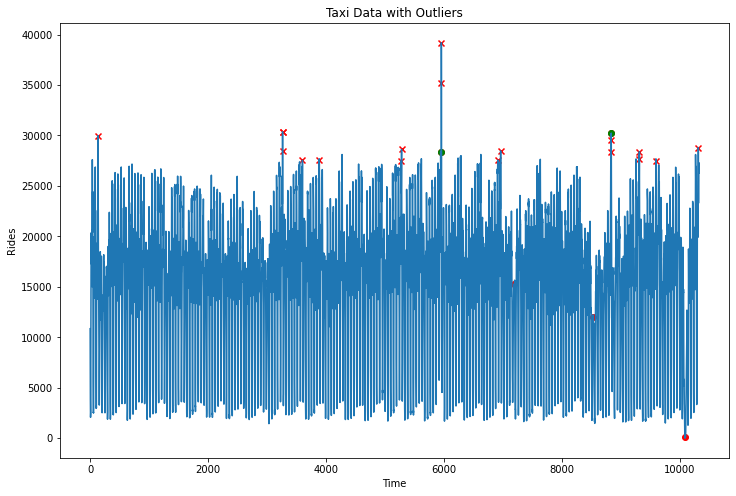

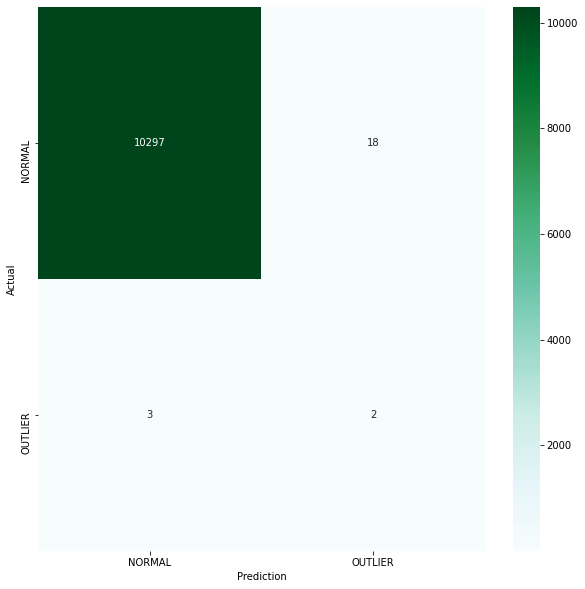

              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00     10315
     OUTLIER       0.10      0.40      0.16         5

    accuracy                           1.00     10320
   macro avg       0.55      0.70      0.58     10320
weighted avg       1.00      1.00      1.00     10320



In [ ]:
plot_outliers(X_train, y_train, vote_df.OUTLIER)
plot_confusion(y_train, vote_df.OUTLIER)
print_classification_report(y_train, vote_df.OUTLIER)